In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import copulas as cp
import pyvinecopulib as pv
from statsmodels.graphics import tsaplots
from statsmodels.tsa.stattools import adfuller
from arch import arch_model
from statsmodels.distributions.empirical_distribution import ECDF

import plotly.graph_objects as go
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import os
plt.style.use(['science', 'ggplot-ubs.mplstyle'])
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['ytick.right'] = False

sns.set_context('talk')
palette = sns.color_palette(as_cmap=True)
fmt = 'svg'

DATA = "../../001_Data"
OUT = "../Outputs/Figs"
one_bushel_to_pounds = 60
one_short_ton_to_bushels = 42.08
one_short_ton_to_pounds = one_short_ton_to_bushels*one_bushel_to_pounds

def savefig(name):
    plt.savefig(os.path.join(OUT, f'{name}.{fmt}'))
    
def writeimage(fig, name):
    fig.write_image(f"{OUT}/{name}.{fmt}", scale=3)
    
sns.color_palette()

[(0.30196078431372547, 0.23529411764705882, 0.1843137254901961),
 (0.7529411764705882, 0.44313725490196076, 0.33725490196078434),
 (0.9098039215686274, 0.7803921568627451, 0.403921568627451),
 (0.6431372549019608, 0.21568627450980393, 0.1450980392156863),
 (0.8117647058823529, 0.7411764705882353, 0.6078431372549019),
 (0.6823529411764706, 0.6901960784313725, 0.7019607843137254),
 (0.9294117647058824, 0.8431372549019608, 0.615686274509804),
 (0.4823529411764706, 0.49019607843137253, 0.5019607843137255),
 (0.9019607843137255, 0.7137254901960784, 0.6431372549019608),
 (0.27450980392156865, 0.2784313725490196, 0.28627450980392155),
 (0.6313725490196078, 0.8, 0.8941176470588236),
 (0.0, 0.5372549019607843, 0.5529411764705883),
 (0.7254901960784313, 0.6980392156862745, 0.6392156862745098),
 (0.22745098039215686, 0.3411764705882353, 0.5411764705882353),
 (0.7529411764705882, 0.8196078431372549, 0.6078431372549019),
 (0.4823529411764706, 0.4196078431372549, 0.34901960784313724),
 (0.6862745098039216, 0.7372549019607844, 0.8352941176470589),
 (0.4588235294117647, 0.592156862745098, 0.19215686274509805),
 (0.8784313725490196, 0.8352941176470589, 0.7411764705882353),
 (0.21176470588235294, 0.5725490196078431, 0.792156862745098),
 (0.6509803921568628, 0.7450980392156863, 0.396078431372549),
 (0.4235294117647059, 0.5294117647058824, 0.7019607843137254),
 (0.7529411764705882, 0.6, 0.4745098039215686),
 (0.592156862745098, 0.8274509803921568, 0.8),
 (0.43529411764705883, 0.7137254901960784, 0.8745098039215686),
 (0.8745098039215686, 0.6784313725490196, 0.13333333333333333),
 (0.3333333333333333, 0.6941176470588235, 0.7058823529411765)]

In [2]:
soybean = pd.read_csv(os.path.join(DATA, 'Soybean.csv'), index_col='Date', parse_dates=True, dayfirst=True)
soybean_oil = pd.read_csv(os.path.join(DATA, 'SoybeanOil.csv'), index_col='Date', parse_dates=True, dayfirst=True)*100*0.11
soybean_meal = pd.read_csv(os.path.join(DATA, 'SoybeanMeal.csv'), index_col='Date', parse_dates=True, dayfirst=True)*0.022
data = soybean.join(soybean_oil, how='outer').join(soybean_meal, how='outer').ffill().resample('M').last().dropna().sort_index()
data.columns = ['Soybean', 'Soybean Oil', 'Soybean Meal']
data['Crush Spread'] = data['Soybean Meal'] + data['Soybean Oil'] - data['Soybean']

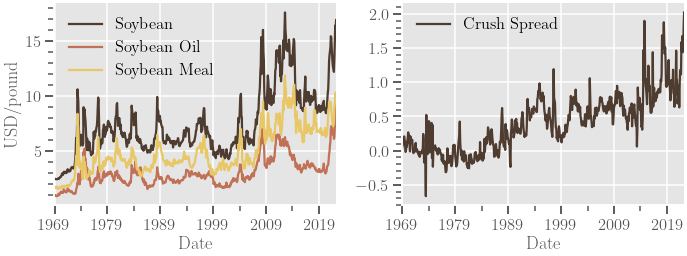

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
data.drop(['Crush Spread'], axis = 1).plot(ax = ax[0])
data['Crush Spread'].plot(ax = ax[1], legend = True)
ax[0].set_ylabel('USD/pound')
plt.tight_layout()
savefig('Data')

In [4]:
data.tail()

,Soybean,Soybean Oil,Soybean Meal,Crush Spread
Date,,,,
2021-12-31,13.3715,6.2128,8.83564,1.67694
2022-01-31,14.9050,7.1302,9.21580,1.44100
2022-02-28,16.3825,7.9849,9.85644,1.45884
2022-03-31,16.1825,7.6934,10.28500,1.79590
2022-04-30,16.8945,9.3698,9.54668,2.02198


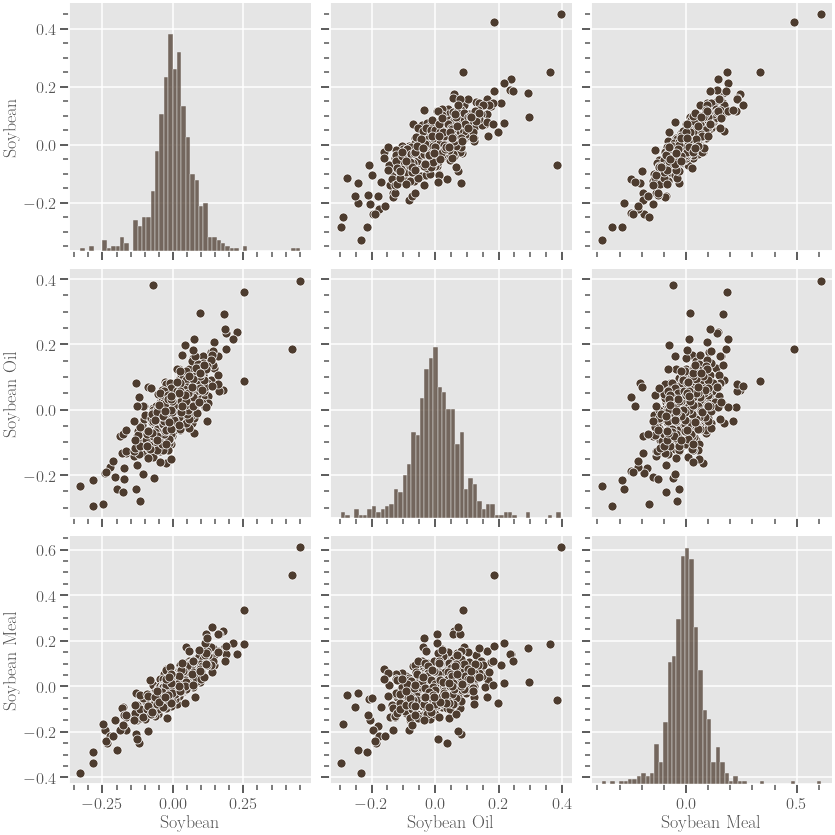

In [4]:
logrets_df = np.log(data.drop(['Crush Spread'], axis=1)).diff().dropna()
_ = sns.pairplot(logrets_df, height=4, aspect=1,
    diag_kws = {'color': palette[0], 'bins': 50},
    plot_kws = {'color': palette[0]})
savefig('PairPlot')

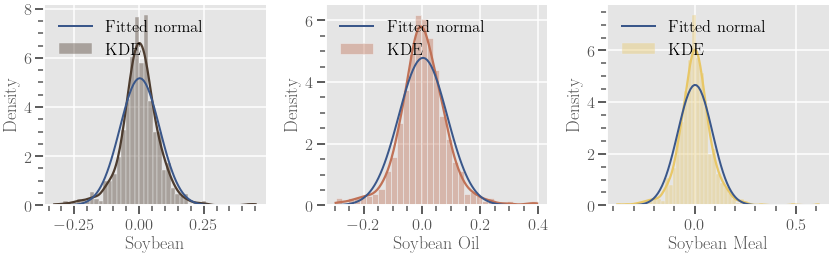

In [5]:
def plot_norm_fit(axes, data):
    xmin, xmax = data.min(), data.max()
    x = np.linspace(xmin, xmax, 100)
    fit = norm.fit(data)
    p = norm.pdf(x, *fit)
    axes.plot(x, p, linewidth=2, color = palette[13], label = 'Fitted normal')
    axes.legend(loc='upper left')

assets = ['Soybean', 'Soybean Oil', 'Soybean Meal']
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
norm_fits = [norm.fit(logrets_df[asset]) for asset in assets]

for (axis, asset, col) in zip(ax.ravel(), assets, [0, 1, 2]):
    sns.histplot(logrets_df[asset], alpha=0.4, kde=True, stat='density', ax = axis,
                 color=palette[col], label = 'KDE')
    plot_norm_fit(axis, logrets_df[asset])

plt.tight_layout()
savefig('KDEs')

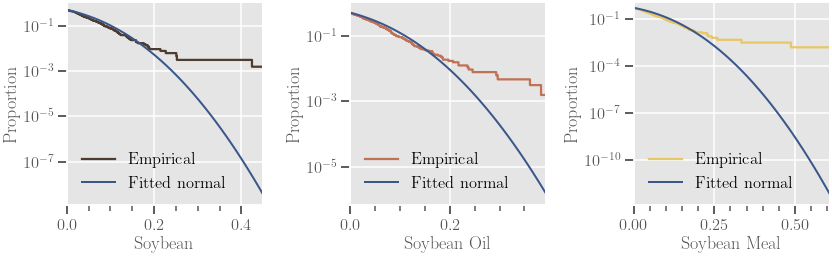

In [6]:
def plot_fit_survival(axes, data):
    xmin, xmax = data.min(), data.max()
    x = np.linspace(xmin, xmax, 100)
    fit = norm.fit(data)
    p = 1 - norm.cdf(x, *fit)
    axes.plot(x, p, color = palette[13], linewidth=2, label='Fitted normal')

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
logscale = True

for (axis, asset, col) in zip(ax.ravel(), assets, [0, 1, 2]):
    sns.ecdfplot(logrets_df[asset], ax = axis, complementary=True, label='Empirical', color=palette[col])
    plot_fit_survival(axis, logrets_df[asset])
    axis.set_xlim(0, logrets_df[asset].max()*0.99)
    
    if logscale:
        axis.set_yscale('log')
    else:
        axis.set_ylim(0, 0.5)

    axis.legend()
    
plt.tight_layout()
savefig('TailAnalysis')

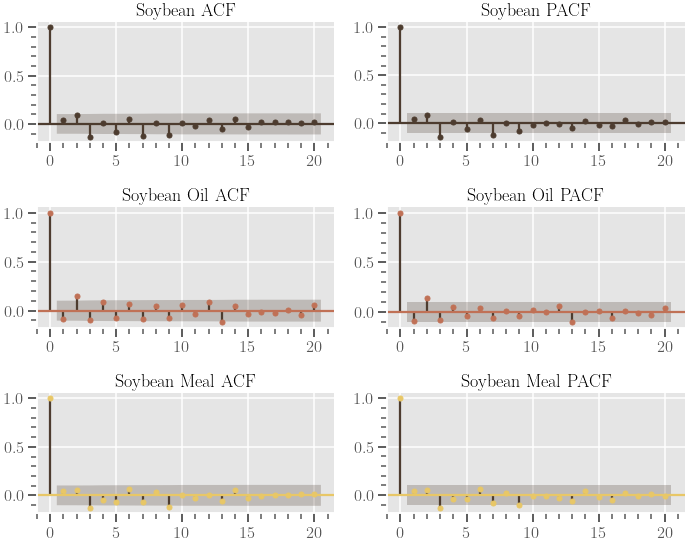

In [7]:
plt.figure(figsize=(10, 8))
zero=True
for ind, (asset, col) in enumerate(zip(assets, [0, 1, 2])):
    ax = plt.subplot(3, 2, 2*ind+1)
    _ = tsaplots.plot_acf(logrets_df[asset], title=f"{asset} ACF",
                          ax = ax, zero=zero, alpha=0.01, lags=20, color=palette[col])
    ax = plt.subplot(3, 2, 2*ind+2)
    _ = tsaplots.plot_pacf(logrets_df[asset], title=f"{asset} PACF",
                           ax = ax, zero=zero, alpha = 0.01, lags=20, color=palette[col])

plt.tight_layout()
savefig("TSA")

In [9]:
def adfuller_test(data):
    result=adfuller(data)
    labels = ['ADF Test Statistic','p-value', '#Lags Used', 'Number of Observations']
    for value, label in zip(result, labels):
        print(f"{label}: {str(value)}")

    if result[1] <= 0.05:
        print("Reject the null hypothesis. Data is stationary")
    else:
        print("weak evidence against null hypothesis indicating it is non-stationary ")

for asset in assets:
    print(f"{asset} logreturns:")
    adfuller_test(logrets_df[asset])
    print("")

Soybean logreturns:
ADF Test Statistic: -10.122409589809182
p-value: 9.369644518334581e-18
#Lags Used: 8
Number of Observations: 631
Reject the null hypothesis. Data is stationary

Soybean Oil logreturns:
ADF Test Statistic: -11.863968879881153
p-value: 6.7435235663140365e-22
#Lags Used: 3
Number of Observations: 636
Reject the null hypothesis. Data is stationary

Soybean Meal logreturns:
ADF Test Statistic: -9.988157489020171
p-value: 2.0293369780951723e-17
#Lags Used: 8
Number of Observations: 631
Reject the null hypothesis. Data is stationary



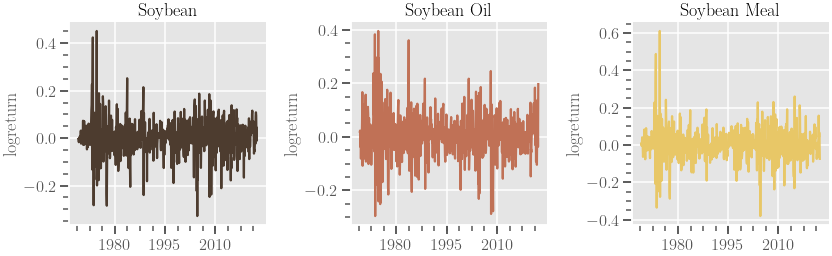

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

for i, (asset, col) in enumerate(zip(assets, [0, 1, 2])):
    ax[i].plot(logrets_df.loc[:, asset], label=asset, color=palette[col])
    ax[i].set_title(asset);
    ax[i].set_ylabel('logreturn')
    ax[i].xaxis.set_major_locator(mdates.YearLocator(15))

plt.tight_layout()
savefig('Heteroskedasticity')

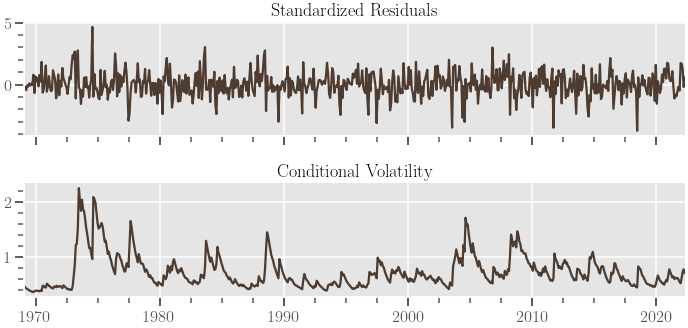

In [11]:
garch_models={}
garch_residuals ={}
for asset in assets:
    model = arch_model(logrets_df[asset], mean='Constant', vol='GARCH', p=1, q=1, dist='normal', rescale=True)
    res = model.fit(disp='off')
    garch_models[asset] = res
    garch_residuals[asset] = res.resid/res.conditional_volatility
    
garch_residuals = pd.DataFrame.from_dict(garch_residuals)
_ = garch_models[assets[0]].plot()
plt.tight_layout()
savefig('GARCH')

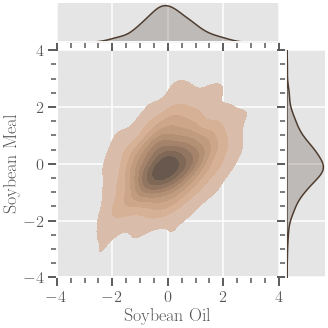

In [12]:
_=sns.jointplot(
    data=garch_residuals,
    x=assets[1], y=assets[2],
    height=5, kind="kde", 
    fill=True, xlim=(-4, 4), ylim=(-4, 4))

savefig(f'Jointplot')

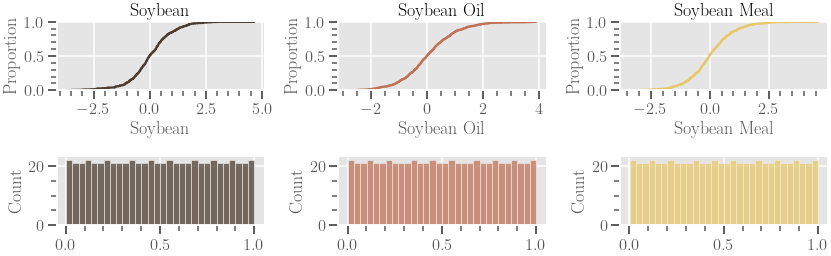

In [13]:
ecdfs = {asset: ECDF(garch_residuals[asset]) for asset in assets}

fig = plt.figure(figsize=(12, 4))
for ind, asset in enumerate(assets):
    ax = plt.subplot(2, 3, ind+1)
    sns.ecdfplot(garch_residuals[asset], ax = ax, color=palette[ind])
    ax.set_title(f"{asset}")

for ind, asset in enumerate(assets):
    ax = plt.subplot(2, 3, ind + 4)
    sns.histplot(ecdfs[asset](garch_residuals[asset]), stat='count', bins=30, ax = ax, color=palette[ind])

plt.tight_layout()
savefig('ECDFs')

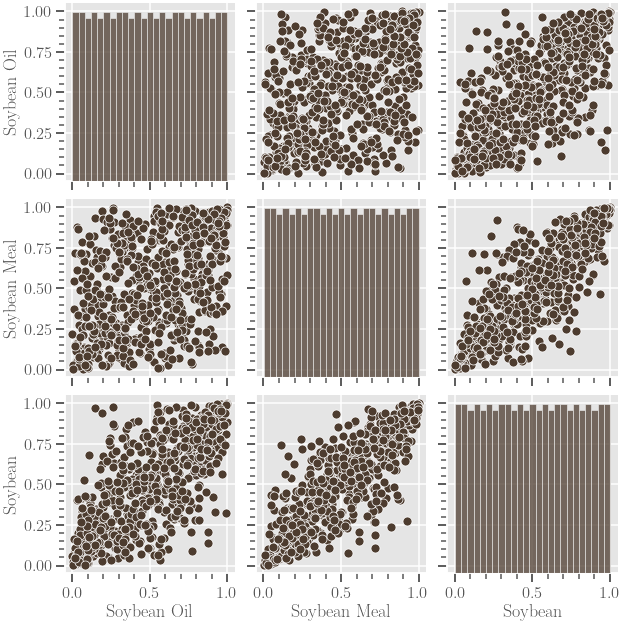

In [14]:
garch_residuals_u_df = logrets_df.iloc[:, 1:].copy()
for ind, asset in enumerate(assets):
    garch_residuals_u_df[asset] = ecdfs[asset](garch_residuals[asset])
    
_ = sns.pairplot(garch_residuals_u_df, height=3, aspect=1,
                 diag_kws = {'color': palette[0], 'bins': 25},
                 plot_kws = {'color': palette[0]})
savefig('PairPlotCopulaScale')

In [15]:
family_set = pv.parametric
controls = pv.FitControlsVinecop(family_set = family_set, selection_criterion='aic')
vine = pv.Vinecop(data=garch_residuals_u_df, controls=controls)
vine

<pyvinecopulib.Vinecop>
** Tree: 0
1,3 <-> Gumbel 180°, parameters = 2.04956
2,3 <-> BB7, parameters = 2.01188
2.23419
** Tree: 1
1,2 | 3 <-> Frank, parameters = -4.45935

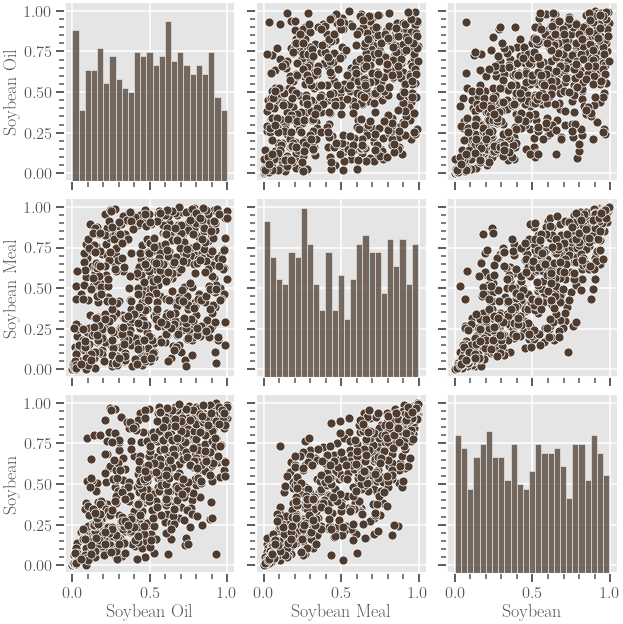

In [16]:
data_u_sim = pd.DataFrame(vine.simulate(n = garch_residuals_u_df.shape[0]),
                          columns = garch_residuals_u_df.columns)

_ = sns.pairplot(data_u_sim, height=3, aspect=1,
                 diag_kws = {'color': palette[0], 'bins': 25},
                 plot_kws = {'color': palette[0]})

In [17]:
from scipy.interpolate import interp1d

def ppf_Soybean(x):
    return np.quantile(garch_residuals["Soybean"], x)
def ppf_SoybeanOil(x):
    return np.quantile(garch_residuals["Soybean Oil"], x)
def ppf_SoybeanMeal(x):
    return np.quantile(garch_residuals["Soybean Meal"], x)

ppfs={'Soybean': ppf_Soybean,
      'Soybean Oil': ppf_SoybeanOil,
      'Soybean Meal': ppf_SoybeanMeal}

sim_garch_residuals = pd.DataFrame.from_dict({asset: ppfs[asset](data_u_sim[asset]) for asset in assets})

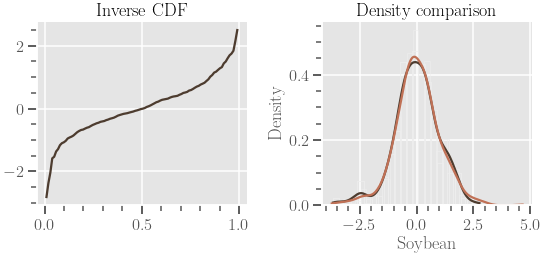

In [18]:
asset_name = 'Soybean'
x = np.linspace(0.01, 0.99, 100)
y = ppfs[asset_name](x)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(x, y)
ax[0].set_title('Inverse CDF')
sns.histplot(sim_garch_residuals[asset_name], alpha=0, kde=True, stat='density', ax = ax[1], color=palette[0])
sns.histplot(garch_residuals[asset_name], alpha=0, kde=True, stat='density', ax = ax[1], color=palette[1])
_ = ax[1].set_title("Density comparison")
plt.tight_layout()

In [19]:
copula_garch_simulated_logrets = {}
for asset in assets:
    mu, omega, alpha, beta = garch_models[asset].params
    scale = garch_models[asset].scale
    e_t = sim_garch_residuals[asset]

    epsilon_t = [garch_models[asset].resid[0]]
    sigma2_t = [garch_models[asset].conditional_volatility[0]**2]

    for e in e_t:
        epsilon_t.append(e*np.sqrt(sigma2_t[-1]))
        sigma2_t.append(omega + alpha*epsilon_t[-1]**2 + beta*sigma2_t[-1])

    copula_garch_simulated_logrets[asset] = (np.array(epsilon_t) + mu)/scale
copula_garch_simulated_logrets = pd.DataFrame.from_dict(copula_garch_simulated_logrets).iloc[1:, :]
copula_garch_simulated_logrets.index = logrets_df.index

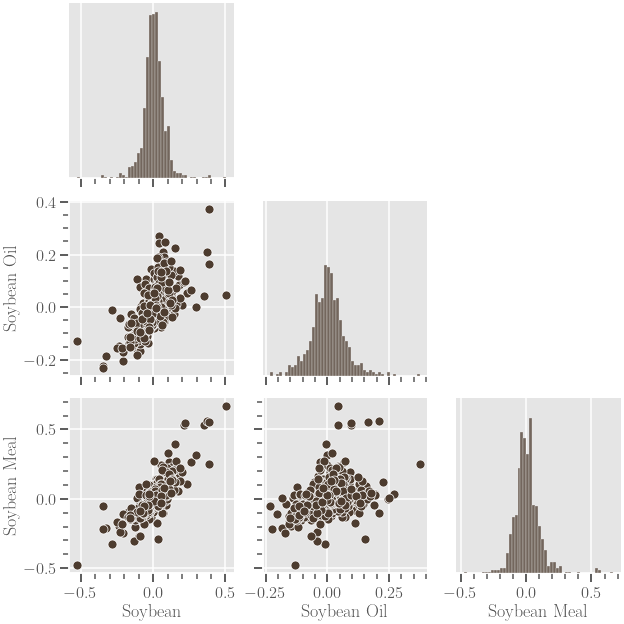

In [20]:
sns.pairplot(copula_garch_simulated_logrets, height=3, aspect=1,corner=True,
                 diag_kws = {'color': palette[0], 'bins': 50},
                 plot_kws = {'color': palette[0]});

In [21]:
logrets_df.corr(method='kendall')

,Soybean,Soybean Oil,Soybean Meal
Soybean,1.000000,0.538389,0.680096
Soybean Oil,0.538389,1.000000,0.295576
Soybean Meal,0.680096,0.295576,1.000000


In [22]:
copula_garch_simulated_logrets.corr(method='kendall')

,Soybean,Soybean Oil,Soybean Meal
Soybean,1.000000,0.502494,0.600831
Soybean Oil,0.502494,1.000000,0.220775
Soybean Meal,0.600831,0.220775,1.000000


<Figure size 720x360 with 0 Axes>

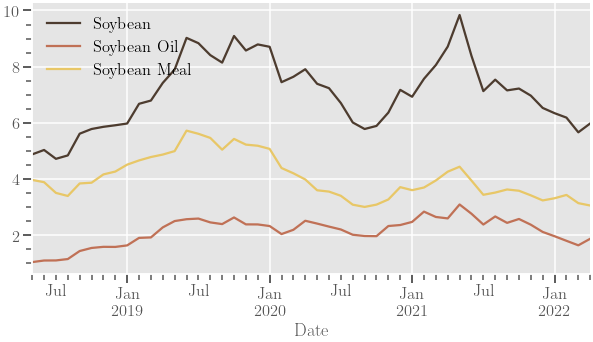

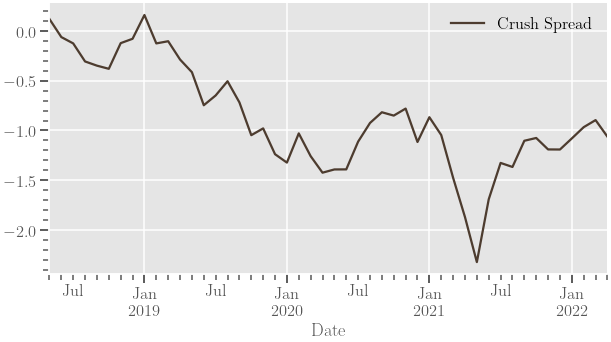

In [23]:
n_steps = 48
plt.figure();
sim_traj_df = data.iloc[n_steps, 0:3]*(np.exp(copula_garch_simulated_logrets.iloc[-n_steps:, :].cumsum()))
sim_traj_df['Crush Spread'] = sim_traj_df['Soybean Meal'] + sim_traj_df['Soybean Oil'] - sim_traj_df['Soybean']
sim_traj_df[assets].plot();

plt.figure();
sim_traj_df['Crush Spread'].plot()
plt.legend();

<AxesSubplot:xlabel='Date'>

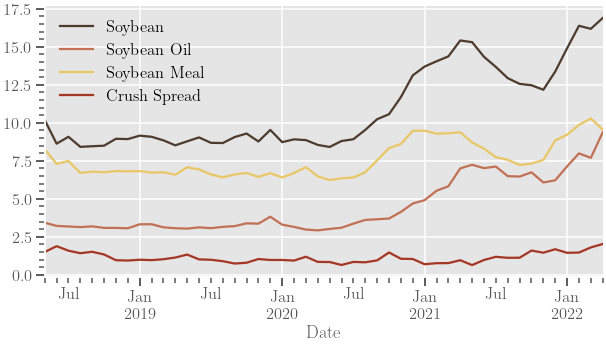

In [24]:
data.iloc[-n_steps:].plot()

In [25]:
def simulation_run(vine_copula, n_months, plot=False):
    
    assets = ['Soybean Oil', 'Soybean Meal', 'Soybean']
    data_uniform = pd.DataFrame(vine_copula.simulate(n=n_months), columns = assets)
    sim_garch_residuals = pd.DataFrame.from_dict({asset: ppfs[asset](data_uniform[asset]) for asset in assets})

    copula_garch_simulated_logrets = {}
    for asset in assets:
        mu, omega, alpha, beta = garch_models[asset].params
        scale = garch_models[asset].scale
        e_t = sim_garch_residuals[asset]

        epsilon_t = [garch_models[asset].resid[0]]
        sigma2_t = [garch_models[asset].conditional_volatility[0]**2]

        for e in e_t:
            epsilon_t.append(e*np.sqrt(sigma2_t[-1]))
            sigma2_t.append(omega + alpha*epsilon_t[-1]**2 + beta*sigma2_t[-1])

        copula_garch_simulated_logrets[asset] = np.array(epsilon_t)/scale
    copula_garch_simulated_logrets = pd.DataFrame.from_dict(copula_garch_simulated_logrets).iloc[1:, :]
    copula_garch_simulated_logrets.index = logrets_df.index[-n_months:]
    sim_traj_df = data.iloc[-n_months, 0:3]*(np.exp(copula_garch_simulated_logrets.cumsum()))
    sim_traj_df = sim_traj_df[['Soybean', 'Soybean Oil', 'Soybean Meal']]
    sim_traj_df['Crush Spread'] = sim_traj_df['Soybean Meal'] + sim_traj_df['Soybean Oil'] - sim_traj_df['Soybean']
    if plot:
        fig, ax = plt.subplots(2, 1, figsize=(8, 8))
        sim_traj_df[['Soybean', 'Soybean Oil', 'Soybean Meal']].plot(ax = ax[0])
        sim_traj_df['Crush Spread'].plot(legend=True, ax = ax[1])
        plt.tight_layout()
    return sim_traj_df

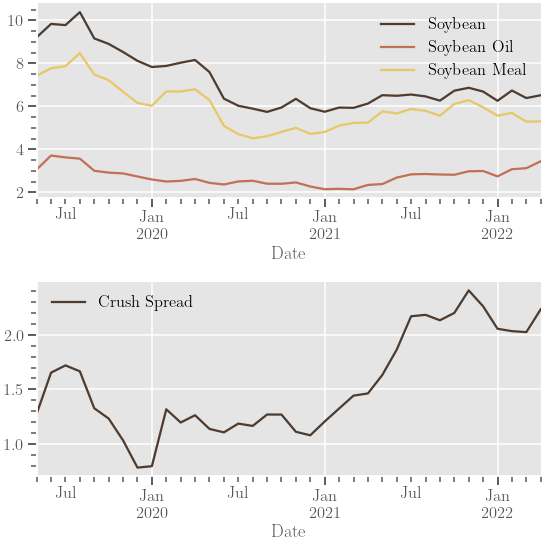

In [26]:
x = simulation_run(vine, 36, plot = True)
savefig('SimulatedPaths3Y');

In [92]:
def payoff(simulation_results, strike, option_type = "CALL"):
    spread_T = simulation_results['Crush Spread'][-1]
    if option_type == "CALL":
        payoff_ = np.maximum(spread_T - K, 0)
    else:
        payoff_ = np.maximum(K - spread_T, 0)
    return payoff_

MC = 10000
K = 1.5
T = 1.0
r = 0.05

payoffs_c = np.zeros(MC)
payoffs_p = np.zeros(MC)
spreads = np.zeros(MC)

for mc in range(MC):
    simulation = simulation_run(vine, int(T*12))
    spreads[mc] = simulation['Crush Spread'][-1]
    payoffs_c[mc] = payoff(simulation, K, "CALL")
    payoffs_p[mc] = payoff(simulation, K, "PUT")

print(f"""
Call spread option
=====================
Instrument: 1-1-1 Soybean Crush
Price: {(payoffs_c*np.exp(-r*T)).mean():.4f}
Std Err: {(payoffs_c*np.exp(-r*T)).std()/np.sqrt(MC):.4f}

""")

print(f"""
Put spread option
=====================
Instrument: 1-1-1 Soybean Crush
Price: {(payoffs_p*np.exp(-r*T)).mean():.4f}
Std Err: {(payoffs_p*np.exp(-r*T)).std()/np.sqrt(MC):.4f}

""")


Call spread option
Instrument: 1-1-1 Soybean Crush
Price: 0.4272
Std Err: 0.0140



Put spread option
Instrument: 1-1-1 Soybean Crush
Price: 0.8988
Std Err: 0.0097




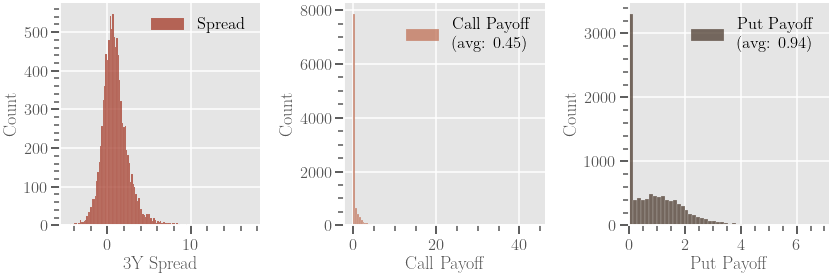

In [101]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
sns.histplot(spreads, kde=False, ax=ax[0], label=f'Spread', color=palette[3])
sns.histplot(payoffs_c, kde=False, ax=ax[1], bins=100, label=f'Call Payoff\n\t(avg: {payoffs_c.mean():.2f})', color=palette[1])
sns.histplot(payoffs_p, kde=False, ax=ax[2], label=f'Put Payoff\n\t(avg: {payoffs_p.mean():.2f})', color=palette[0])
plt.tight_layout()
ax[0].legend()
ax[0].set_xlabel('3Y Spread')
ax[0].set_xlim(np.quantile(spreads, [0.001, 0.999]))
ax[1].legend()
ax[1].set_xlabel('Call Payoff')
ax[2].legend()
ax[2].set_xlabel('Put Payoff')
ax[2].set_xlim(np.quantile(payoffs_p, [0.001, 0.999]))
savefig("PayoffsDistribution");

In [3]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
pio.templates.default = "ggplot2"

def plot_copula_surface(cop, cop_family_name, colorscale = 'turbid_r'):
    margin = 0.05

    x = np.linspace(margin, 1-margin, 100)
    y = np.linspace(margin, 1-margin, 100)
    X,Y = np.meshgrid(x,y)
    points2D = np.vstack([X.flatten(),Y.flatten()]).T

    Z = cop.pdf(points2D)
    Z = np.reshape(Z, np.shape(X))

    fig = go.Figure(data=[go.Surface(z=Z, x=X, y=Y, 
                                     colorscale=colorscale, showscale=False, 
                                     contours = {"z": {"show": True, 
                                                       "start": Z.min(),
                                                       "end": Z.max(), 
                                                       "size": 0.5, 
                                                       "color": "white"}})])

    camera = dict(
        center=dict(x=0, y=0, z=0),
        eye=dict(x=-0.8, y=-1.35, z=1))

    fig.update_layout(title=f"{cop_family_name} copula", autosize=False,
                      width=500, height=500,
                      margin=dict(l=0, r=0, b=10, t=40), scene_camera=camera)
    return fig

def plot_copula_contour(cop, cop_family_name, colorscale = 'turbid_r', 
                        n_contours= 20, margin = 0.05, contour_margin=0.05,
                        fill=True, scale_normal=False):
    
    if scale_normal:
        margin = 0.05
        x = np.linspace(-3+margin, 3-margin, 100)

        X,Y = np.meshgrid(x,x)
        NX = norm.cdf(X)
        NY = norm.cdf(Y)
        NGRID = np.stack((np.ravel(NX),np.ravel(NY)), axis = 1)

        nx = norm.pdf(x).reshape((1,len(x)))
        adj = (nx.transpose()*nx).ravel()

        nx = norm.pdf(x).reshape((1,len(x)))
        adj = (nx.transpose()*nx).ravel()

        Z = cop.pdf(NGRID)
        Z = np.reshape(Z*adj, np.shape(X))
    else:
        x = np.linspace(margin, 1-margin, 100)
        y = np.linspace(margin, 1-margin, 100)
        X,Y = np.meshgrid(x,y)
        points2D = np.vstack([X.flatten(),Y.flatten()]).T

        Z = cop.pdf(points2D)
        Z = np.reshape(Z, np.shape(X))

    c_start = np.quantile(Z, contour_margin/2)
    c_end = np.quantile(Z, 1 - contour_margin/2)
    c_size = (c_end - c_start)/n_contours
    if fill:
        fig = go.Figure(data=[go.Contour(z= Z,x= x, y= x,
                                         line_smoothing = 0,
                                         colorscale = colorscale,
                                         contours=dict(start=c_start,
                                                       end=c_end,
                                                       size=c_size))])
    else:
        fig = go.Figure(data=[go.Contour(z=Z,x =x, y=x,
                                         contours_coloring='lines',
                                         line_width=2,
                                         colorscale=colorscale,
                                         contours=dict(start=c_start,
                                                       end=c_end,
                                                       size=c_size))])
    camera = dict(
        center=dict(x=0, y=0, z=0),
        eye=dict(x=-0.8, y=-1.35, z=1))

    fig.update_layout(title=f"{cop_family_name} copula", autosize=False,
                      width=500, height=500,
                      margin=dict(l=0, r=0, b=10, t=40), scene_camera=camera)
    return fig

In [28]:
fits = {}
copula_figures = {}
family_set = pv.parametric

controls = pv.FitControlsBicop(family_set = family_set, selection_criterion='aic')

for copula_family in family_set:
    cop = pv.Bicop(family=copula_family)
    cop.fit(garch_residuals_u_df[['Soybean Oil', 'Soybean Meal']], controls=controls)
    fits[copula_family.name] = cop
    copula_figures[copula_family.name] = plot_copula_surface(cop, copula_family.name, "turbid_r")

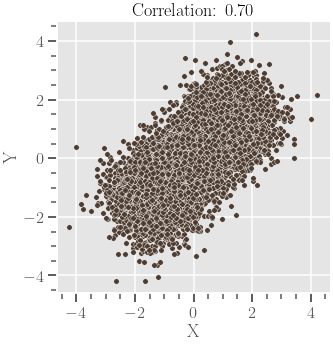

In [127]:
copula = pv.Bicop(family=pv.frank, parameters=[6.5])
fig, axis = plt.subplots()
data_u_sim = pd.DataFrame(copula.simulate(n=20000), 
                          columns = ["Soybean Oil", "Soybean Meal"])
data_u_sim = data_u_sim.apply(lambda x: norm.ppf(x))
sns.scatterplot(data = data_u_sim, x="Soybean Oil", y="Soybean Meal", s=30, ax = axis)
axis.set_xlabel("X")
axis.set_ylabel("Y")
axis.set_title(f"Correlation: {data_u_sim.corr().iloc[0, 1]:.2f}")
axis.set_aspect('equal')

plot_copula_surface(best_fit, f"Best fit copula: {best_fit.family.name}")## PLOTS for KKMF

In [29]:
from scipy.spatial import Delaunay
import plotly.figure_factory as ff
import plotly.express as px

copula = pv.Bicop(family=pv.gumbel, parameters=[2.0])
margin=0.06
u = np.linspace(margin, 1-margin, 15)
v = np.linspace(margin, 1-margin, 15)
u,v = np.meshgrid(u,v)
u = u.flatten()
v = v.flatten()

points2D = np.vstack([u,v]).T
tri = Delaunay(points2D)
simplices = tri.simplices

Z = copula.pdf(points2D)
Z = np.reshape(Z, np.shape(u))

fig = ff.create_trisurf(x=u, y=v, z=Z,
                        simplices=simplices,
                        title="T Copula density", aspectratio=dict(x=1, y=1, z=1), colormap = px.colors.sequential.turbid_r)

camera = dict(
    center=dict(x=0, y=0, z=0),
    eye=dict(x=-0.8, y=-1.35, z=1))

fig.update_layout(title=f"{copula.family.name.capitalize()} copula", autosize=False,
                  width=500, height=500,
                  margin=dict(l=0, r=0, b=10, t=40), scene_camera=camera)
writeimage(fig, 'VisualGumbel')

In [26]:
#### DIFFERENT CORRELATIONS
cops = {'Gaussian100': pv.Bicop(family = pv.gaussian, parameters = [1.0]), 
        'Gaussian90': pv.Bicop(family = pv.gaussian, parameters = [0.9]),
        'Gaussian0': pv.Bicop(family = pv.gaussian, parameters = [0]),
        'Gaussian-20': pv.Bicop(family = pv.gaussian, parameters = [-.4]), 
        'Gaussian-50': pv.Bicop(family = pv.gaussian, parameters = [-.8]),
        'Gaussian-100': pv.Bicop(family = pv.gaussian, parameters = [-1.0])}
sims = {}
for (name, copula), axis in zip(cops.items(), ax.ravel()):
    data_u_sim = pd.DataFrame(copula.simulate(n=1000), 
                              columns = ["Soybean Oil", "Soybean Meal"])
    sims[name] = data_u_sim.apply(lambda x: norm.ppf(x))

fig, ax = plt.subplots(2, 3, figsize=(12, 8))
for (name, copula), axis in zip(cops.items(), ax.ravel()):
    data_u_sim = sims[name]
    sns.scatterplot(data = data_u_sim, x="Soybean Oil", y="Soybean Meal", s=30, ax = axis)
    axis.set_xlabel("X")
    axis.set_ylabel("Y")
    axis.set_title(f"Correlation: {copula.parameters[0, 0]:.2f}")
    axis.set_aspect('equal')

plt.tight_layout()
savefig('NormalWithDifferentCorr')
plt.close()

In [142]:
#### DIFFERENT DATA, SAME CORRELATION
corr=0.7
cops = {'Gaussian': pv.Bicop(family = pv.gaussian, parameters = [0.7]), 
        'Student': pv.Bicop(family=pv.student, parameters=[0.72, 2]),
        'Clayton': pv.Bicop(family=pv.clayton, parameters=[2.1]),
        'Frank': pv.Bicop(family=pv.frank, parameters=[6.5])}
sims = {}
for (name, copula), axis in zip(cops.items(), ax.ravel()):
    data_u_sim = pd.DataFrame(copula.simulate(n=4000), 
                              columns = ["Soybean Oil", "Soybean Meal"])
    sims[name] = data_u_sim.apply(lambda x: norm.ppf(x))

fig, ax = plt.subplots(2, 2, figsize=(8, 8))
for (name, copula), axis in zip(cops.items(), ax.ravel()):
    data_u_sim = sims[name]
    sns.scatterplot(data = data_u_sim, x="Soybean Oil", y="Soybean Meal", s=30, ax = axis)
    axis.set_xlabel("X")
    axis.set_ylabel("Y")
    axis.set_aspect('equal')

plt.tight_layout()
#savefig('SameCorrelationNoTitle')
plt.close()

fig, ax = plt.subplots(2, 2, figsize=(8, 8))
for (name, copula), axis in zip(cops.items(), ax.ravel()):
    data_u_sim = sims[name]
    sns.scatterplot(data = data_u_sim, x="Soybean Oil", y="Soybean Meal", s=30, ax = axis)
    axis.set_xlabel("X")
    axis.set_ylabel("Y")
    axis.set_title(f"Correlation: {data_u_sim.corr().iloc[0, 1]:.2f}")
    axis.set_aspect('equal')

plt.tight_layout()
#savefig('SameCorrelationCorrReveal')
plt.close()

fig, ax = plt.subplots(2, 2, figsize=(8, 8))
for (name, copula), axis in zip(cops.items(), ax.ravel()):
    data_u_sim = sims[name]
    sns.scatterplot(data = data_u_sim, x="Soybean Oil", y="Soybean Meal", s=30, ax = axis)
    axis.set_xlabel("X")
    axis.set_ylabel("Y")
    axis.set_title(f"{name}: {*[x[0] for x in copula.parameters],}")
    axis.set_aspect('equal')

plt.tight_layout()
#savefig('SameCorrelationCopulaParams')
plt.close()

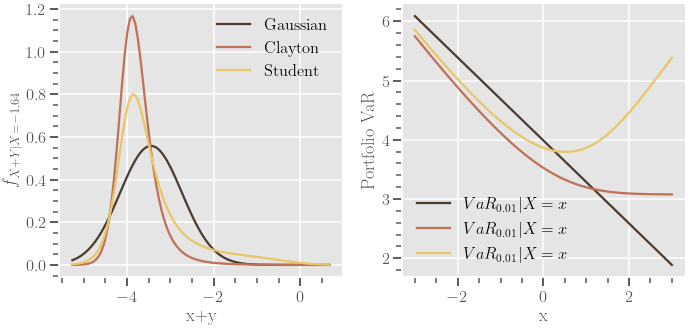

In [10]:
##  VAR examples
examples = {'Gaussian': pv.Bicop(family = pv.gaussian, parameters = [0.7]),
            'Clayton': pv.Bicop(family=pv.clayton, parameters=[2.1]),
            'Student': pv.Bicop(family=pv.student, parameters=[0.72, 2])}

xaxis = np.linspace(-3, 3, 100)
dx = xaxis[1] - xaxis[0]
unifaxis = norm.cdf(xaxis)
cond = np.full(shape=(unifaxis.shape[0], ), fill_value=0.05)
x = np.array([cond, unifaxis]).T

fig, ax = plt.subplots(1, 2)
for ind, (name, copula) in enumerate(examples.items()):
    cond_cdf = copula.hfunc1(x)
    density = (cond_cdf[1:] - cond_cdf[:-1])/(xaxis[1:] - xaxis[:-1])
    ax[0].plot(xaxis[1:] + norm.ppf(0.01), density, label = name)
    
ax[0].legend()
ax[0].set_xlabel('x+y')
ax[0].set_ylabel('$f_{X + Y | X = -1.64}$')

unifaxis = norm.cdf(xaxis)
cond = np.full(shape=(unifaxis.shape[0], ), fill_value=0.01)
x = np.array([unifaxis, cond]).T

for ind, (name, copula) in enumerate(examples.items()):
    cond_quantile = -(norm.ppf(copula.hinv1(x)) + norm.ppf(0.01))
    ax[1].plot(xaxis, cond_quantile, label = '$VaR_{0.01} | X = x$')
ax[1].legend()
ax[1].set_ylabel('Portfolio VaR')
ax[1].set_xlabel('x')
plt.tight_layout()
savefig('VARConditionalDistributions')

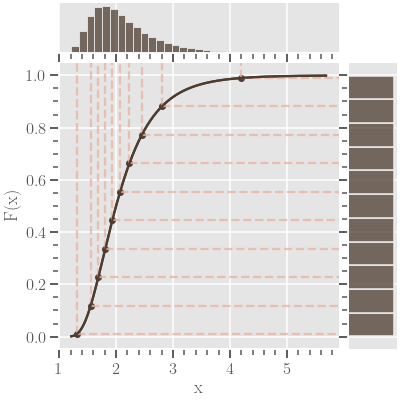

In [29]:
## PIT
from scipy.stats import lognorm
dist = lognorm(0.5, 1)
u = np.linspace(0.001, 0.999, 1000)
df = pd.DataFrame.from_dict({'F(x)': u,
                             'x': dist.ppf(u)})
grid = sns.JointGrid(data=df, x="x", y="F(x)")
marg_func = sns.histplot
grid.plot_joint(plt.plot, color=palette[0])    
for y in np.linspace(0.01, 0.99, 10):
    xlims = plt.xlim()
    ylims = plt.ylim()
    xl = (dist.ppf(y) - xlims[0])/(xlims[1] - xlims[0])
    yl = (y - ylims[0])/(ylims[1] - ylims[0])
    plt.axhline(y=y, xmin=xl, xmax=1, color=palette[8], linestyle='--', alpha=0.8)
    plt.axvline(x=dist.ppf(y), ymin=yl, ymax=1, color=palette[8], linestyle='--', alpha = 0.8)
grid.plot_joint(plt.plot, color=palette[0])        
for y in np.linspace(0.01, 0.99, 10):
    plt.scatter(x = dist.ppf(y), y = y, marker='o', c=palette[0], s=30)
grid.plot_marginals(marg_func, color=palette[0]);

savefig("PIT")

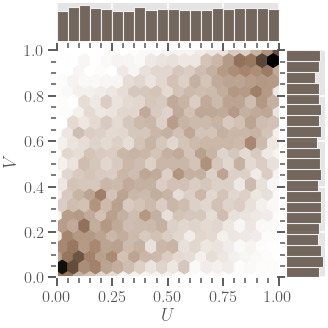

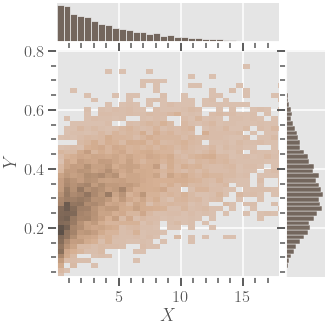

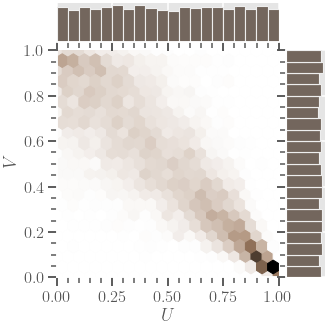

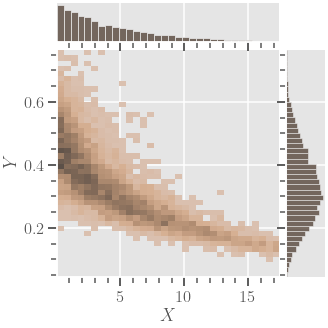

In [109]:
#### Copulas - First examples
from scipy.stats import expon, gamma, t, beta
cops = {'Gaussian': pv.Bicop(family = pv.gaussian, parameters = [0.6]),
        'Clayton': pv.Bicop(family=pv.clayton, parameters=[4], rotation=90)}

for name, copula in cops.items():
    data_u_sim = pd.DataFrame(copula.simulate(n=8000), 
                              columns = ["$U$", "$V$"])
    _=sns.jointplot(data=data_u_sim,
                    x="$U$", y="$V$", 
                    height=5, kind="hex", 
                    xlim=(0, 1), ylim=(0, 1))
    savefig(f'BivariateCopula{name}')
    
    data_u_sim['$X$'] = expon.ppf(data_u_sim[['$U$']], 0.0, 5) 
    data_u_sim['$Y$'] = beta.ppf(data_u_sim[['$V$']], 5, 10, 0, 1) 
    xlims = np.quantile(data_u_sim['$X$'], [0, 0.97])
    ylims = np.quantile(data_u_sim['$Y$'], [0, 1])
    
    _=sns.jointplot(data=data_u_sim,
                    x="$X$", y="$Y$", 
                    height=5, kind="hist", 
                    xlim=xlims,
                    ylim=ylims)
    savefig(f'BivariateCopula{name} - Normal scale')

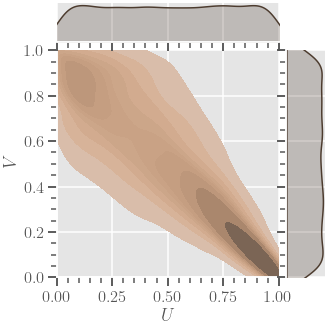

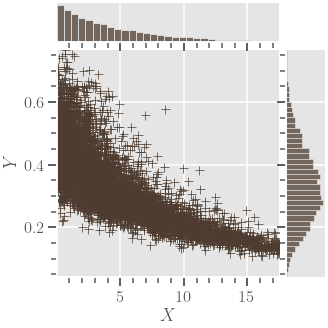

In [107]:
#### Copulas - definition
from scipy.stats import expon, gamma, t, beta
cops = {'Clayton': pv.Bicop(family=pv.clayton, parameters=[4], rotation=90)}

for name, copula in cops.items():
    data_u_sim = pd.DataFrame(copula.simulate(n=8000), 
                              columns = ["$U$", "$V$"])
    _=sns.jointplot(data=data_u_sim,
                    x="$U$", y="$V$", 
                    height=5, kind="kde", fill = True,
                    xlim=(0, 1), ylim=(0, 1))
    savefig(f'DefinitionCopulaUniform{name}')
    
    data_u_sim['$X$'] = expon.ppf(data_u_sim[['$U$']], 0.0, 5) 
    data_u_sim['$Y$'] = beta.ppf(data_u_sim[['$V$']], 5, 10, 0, 1) 
    xlims = np.quantile(data_u_sim['$X$'], [0, 0.97])
    ylims = np.quantile(data_u_sim['$Y$'], [0, 1])
    
    _=sns.jointplot(data=data_u_sim,
                    x="$X$", y="$Y$",
                    height=5, kind="scatter", marker="+", edgecolor=None,
                    xlim=xlims,
                    ylim=ylims)
    savefig(f'DefinitionCopulaData{name}')

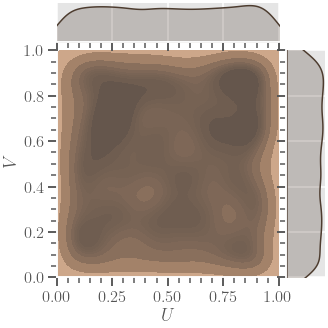

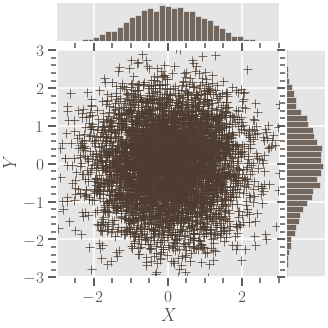

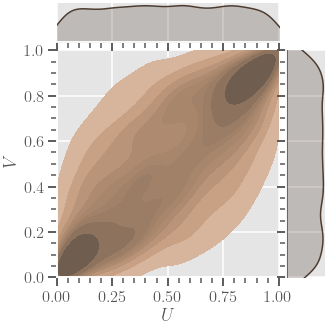

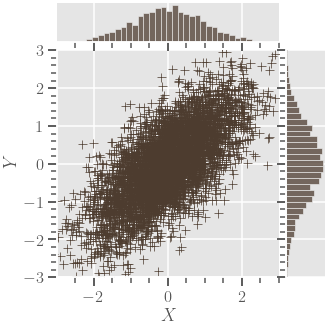

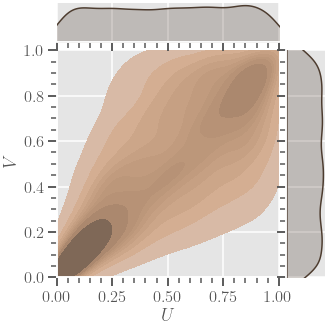

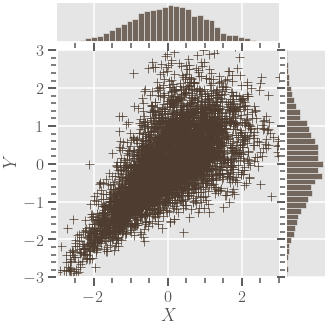

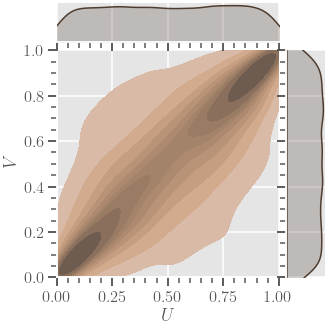

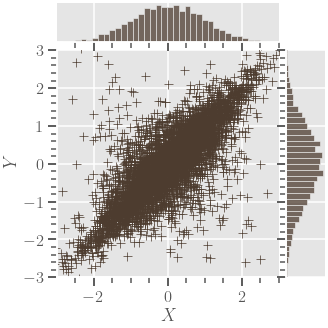

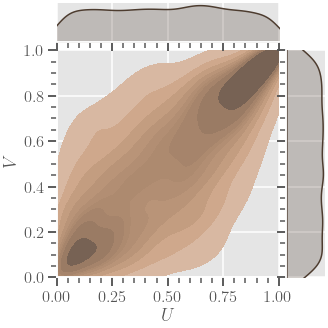

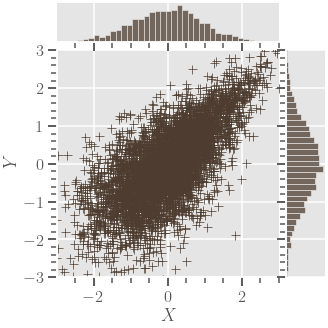

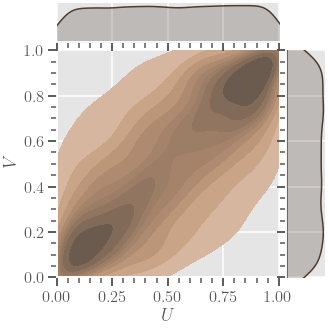

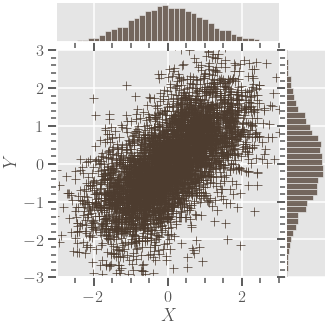

In [104]:
#### Copulas - First examples
cops = {'Independence': pv.Bicop(family = pv.indep, parameters=[]),
        'Gaussian': pv.Bicop(family = pv.gaussian, parameters = [0.7]),
        'Clayton': pv.Bicop(family=pv.clayton, parameters=[2]), 
        'Student': pv.Bicop(family=pv.student, parameters=[0.8, 2]),
        'Gumbel': pv.Bicop(family=pv.gumbel, parameters=[2]),
        'Frank': pv.Bicop(family=pv.frank, parameters=[5])}

for name, copula in cops.items():
    fig = plot_copula_contour(copula, name, n_contours = 10)
    writeimage(fig, f"{name}ContourFilled")
    fig = plot_copula_contour(copula, name, n_contours = 10, fill=False)
    writeimage(fig, f"{name}ContourLines")
    fig = plot_copula_contour(copula, name, n_contours = 10, fill=False, scale_normal=True)
    writeimage(fig, f"{name}ContourLinesNormal")
    fig = plot_copula_surface(copula, name)
    writeimage(fig, f"{name}Surface")
    
for name, copula in cops.items():
    data_u_sim = pd.DataFrame(copula.simulate(n=5000), 
                              columns = ["$U$", "$V$"])
    sns.jointplot(data=data_u_sim,
                  x="$U$", y="$V$", 
                  height=5, kind="kde", fill=True, 
                  xlim=(0, 1), ylim=(0, 1))
    savefig(f'ExampleBivariateCopula{name}')
    
    data_u_sim['$X$'] = norm.ppf(data_u_sim['$U$'])
    data_u_sim['$Y$'] = norm.ppf(data_u_sim['$V$'])
    sns.jointplot(data=data_u_sim,
                  x="$X$", y="$Y$", 
                  height=5, kind="scatter", marker="+", edgecolor=None,
                  xlim=(-3, 3), ylim=(-3, 3))
    savefig(f'ExampleNormalBivariateCopula{name}')


In [ ]:
## Tail dependence

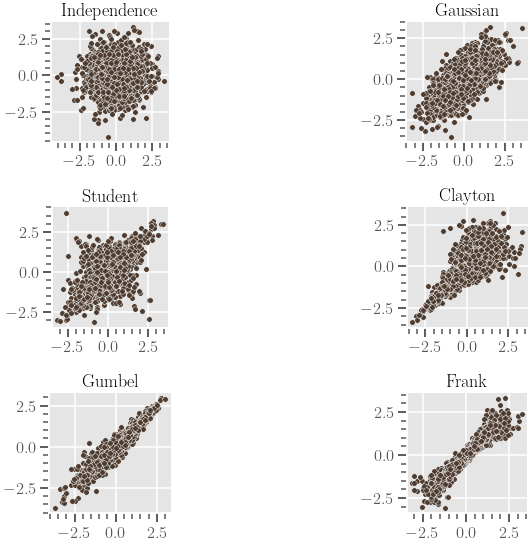

In [85]:
cops = {'Independence': pv.Bicop(family = pv.indep),
        'Gaussian': pv.Bicop(family = pv.gaussian, parameters = [0.7]), 
        'Student': pv.Bicop(family=pv.student, parameters=[0.7, 2]),
        'Clayton': pv.Bicop(family=pv.clayton, parameters=[3]), 
        'Gumbel': pv.Bicop(family=pv.gumbel, parameters=[5]),
        'Frank': pv.Bicop(family=pv.frank, parameters=[30])}

for (name, copula), axis in zip(cops.items(), ax.ravel()):
    data_u_sim = pd.DataFrame(copula.simulate(n=2000), 
                              columns = ["Soybean Oil", "Soybean Meal"])
    #data_u_sim = data_u_sim.apply(lambda x: norm.ppf(x))
    sns.scatterplot(data = data_u_sim, x="Soybean Oil", y="Soybean Meal", s=30, ax = axis)
    axis.set_xlabel("")
    axis.set_ylabel("")
    axis.set_title(name)
    axis.set_aspect('equal')
    
plt.tight_layout()
savefig('CopulaExamples')

In [89]:
for name, cop in cops.items():
    subfig = plot_copula_contour(cop, cop_family_name = name, scale_normal=False, fill=False, contour_margin = 0)
    #subfig.update_layout(yaxis=dict(range=[-3, 3]))
    subfig.update_yaxes(scaleanchor = "x", scaleratio = 1)
    subfig.write_image(f"{OUT}/{name}Contour.{fmt}", scale=3)


Fit controls:
---------
<pyvinecopulib.FitControlsBicop>
Family set: Independence, Gaussian, Student, Clayton, Gumbel, Frank, Joe, BB1, BB6, BB7, BB8
Parametric method: mle
Nonparametric method: quadratic
Nonparametric multiplier: 1
Weights: no
Selection criterion: aic
Preselect families: yes
mBIC prior probability: 0.9
Number of threads: 1


Fit results:
------------
             loglik         aic         bic
indep      0.000000    0.000000    0.000000
gaussian  68.615552 -135.231104 -130.769636
student   68.611811 -133.223622 -124.300685
clayton   67.392566 -132.785133 -128.323664
gumbel    45.571963  -89.143926  -84.682458
frank     58.410830 -114.821660 -110.360192
joe       24.149718  -46.299436  -41.837968
bb1       71.401282 -138.802565 -129.879628
bb6       45.571910  -87.143819  -78.220883
bb7       70.616994 -137.233987 -128.311051
bb8       57.196429 -110.392858 -101.469921

Best fit:
---------
<pyvinecopulib.Bicop>
Gumbel 180°, parameters = 1.39231


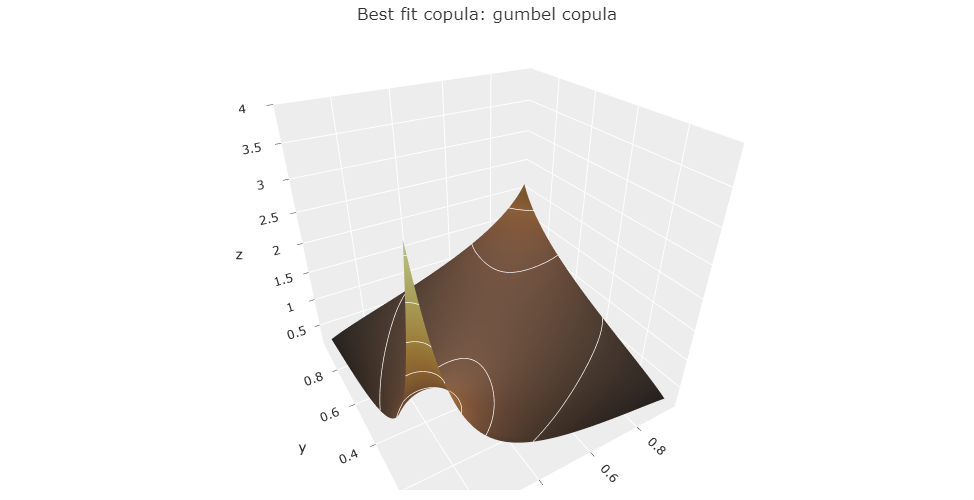

In [103]:
best_fit = pv.Bicop()

best_fit.select(data = garch_residuals_u_df[['Soybean Oil', 'Soybean Meal']], controls = controls)  
fit_results = {}
for family, fitted_copula in fits.items():
    fit_results[family] = {'loglik': fitted_copula.loglik(garch_residuals_u_df[['Soybean Oil', 'Soybean Meal']]),
                           'aic': fitted_copula.aic(garch_residuals_u_df[['Soybean Oil', 'Soybean Meal']]),
                           'bic': fitted_copula.bic(garch_residuals_u_df[['Soybean Oil', 'Soybean Meal']])}
print(f"""
Fit controls:
---------
{controls}

Fit results:
------------
{pd.DataFrame.from_dict(fit_results, orient='index')}

Best fit:
---------
{best_fit}""")

plot_copula_surface(best_fit, f"Best fit copula: {best_fit.family.name}")

In [104]:
fig = plot_copula_surface(best_fit, "Best fit: BB7(1.81, 1.54)")
writeimage(fig, 'BestFitSurface')

fig = plot_copula_contour(best_fit, "Best fit: BB7(1.81, 1.54)", scale_normal=True, fill=False, contour_margin=0)
writeimage(fig, "BestFitContourNorm")

fig = plot_copula_contour(best_fit, "Best fit: BB7(1.81, 1.54)", scale_normal=False, fill=False, contour_margin=0)
writeimage(fig, "BestFitContour")

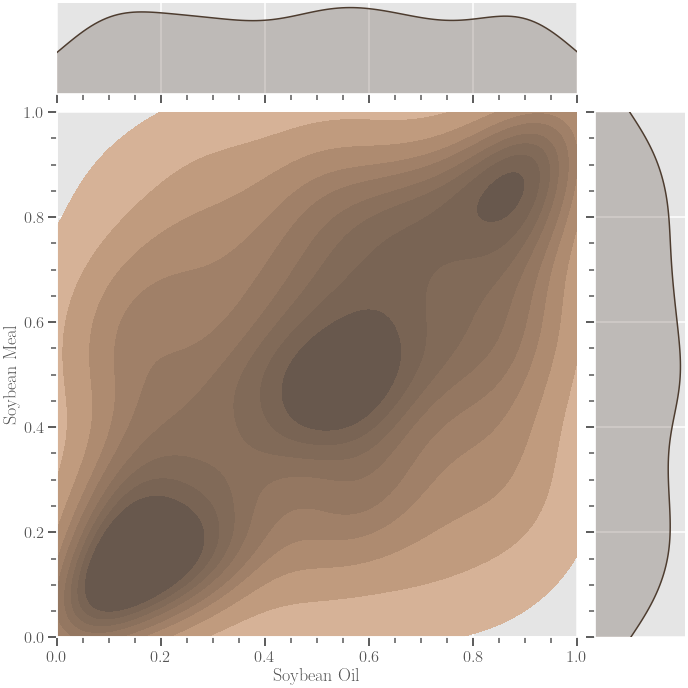

In [108]:
data_u_sim = pd.DataFrame(best_fit.simulate(n=garch_residuals_u_df.shape[0]), columns = ['Soybean Oil', 'Soybean Meal'])

_=sns.jointplot(
    data=data_u_sim,
    x="Soybean Oil", y="Soybean Meal",
    height=10, kind="kde", 
    fill=True, xlim=(0, 1), ylim=(0, 1))
savefig('CopulaRnd2D')

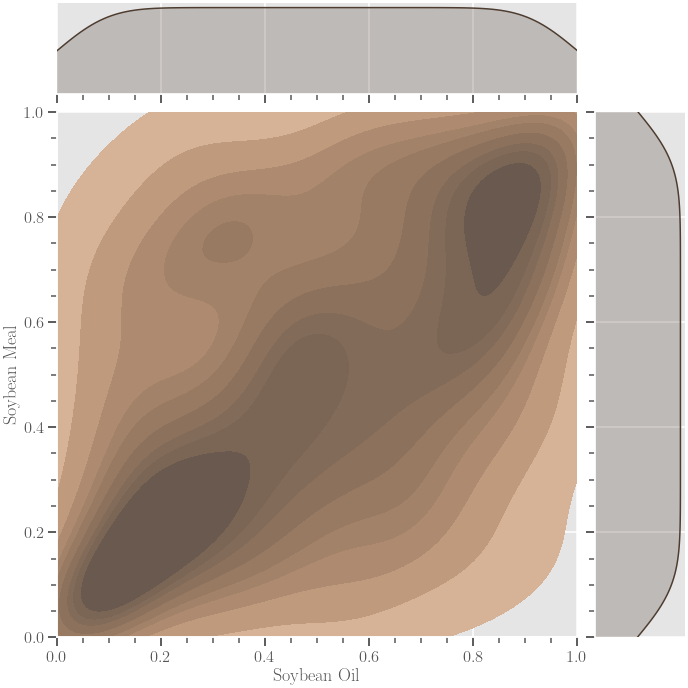

In [109]:
_=sns.jointplot(data=garch_residuals_u_df, x="Soybean Oil", y="Soybean Meal",
                height=10, kind="kde", fill=True, xlim=(0, 1), ylim=(0, 1))

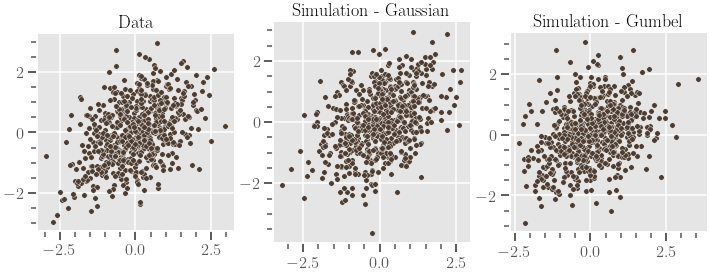

In [128]:
fig = plt.figure()
for ind, (name, copula) in enumerate(zip(['Data', 'Simulation - Gaussian', 'Simulation - Gumbel'],
                                         [None, fits['gaussian'], fits['gumbel']])):
    axis = plt.subplot(1, 3, ind + 1)

    if name == 'Data':
        data_u_sim = garch_residuals_u_df[["Soybean Oil", "Soybean Meal"]]
        mult = 1.0
    else:
        data_u_sim = pd.DataFrame(copula.simulate(n=garch_residuals_u_df.shape[0]), 
                                  columns = ["Soybean Oil", "Soybean Meal"])
        mult = -1.0
    data_u_sim = data_u_sim.apply(lambda x: norm.ppf(x))*mult
    sns.scatterplot(data = data_u_sim, x="Soybean Oil", y="Soybean Meal", s=30, ax = axis)
    axis.set_xlabel("")
    axis.set_ylabel("")
    axis.set_title(name)
    axis.set_aspect('equal')